    # Automatic Jupyter Notebook for OpenML dataset 536: arsenic-male-lung

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import openml as oml
import numpy as np
import pandas as pd
from sklearn import dummy
from sklearn.model_selection import train_test_split
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['figure.dpi']= 120
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 

from preamble import *
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from pymongo import MongoClient

The percentage of unique values for the default target attribute in this data set is 0.0322.
Because this is lower or equal than 5% of the dataset we assume that this is a **classification** problem. 

Calculate baseline accuracy for classification problems using scikit-learn DummyClassifier. 

In [2]:
def baseline(data):
    strategies = ['stratified','most_frequent','prior','uniform']
    baseDict = {}
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    for strat in strategies:
        clf = dummy.DummyClassifier(strategy=strat,random_state=0)
        clf.fit(X_train, y_train)
        baseDict[strat] = clf.score(X_test, y_test)
    return baseDict  

Generates a plot of the classification baseline accuracy of the various baseline strategies using scikit-learn DummyClassifier.


In [47]:
def plot_baseline(scores):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from collections import namedtuple

    strats = scores
    maxBaseline = strats[max(strats, key=strats.get)]
    
    n_groups = len(strats)

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.1

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    plt.bar(range(len(strats)), strats.values(), align='center')
    plt.xticks(range(len(strats)), list(strats.keys()))
    plt.yticks(np.arange(0, 1.1, step=0.2))
    plt.yticks(list(plt.yticks()[0]) + [maxBaseline])

    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=1)
    ax.set_xlabel('Baseline Strategy')
    ax.set_ylabel('Accuracy')
    ax.set_title('Baseline Performance Predicting Feature: ' + data.default_target_attribute)
    plt.axhline(y=maxBaseline, color='r', linestyle='--', label=maxBaseline)
    plt.gca().get_yticklabels()[6].set_color('red')
    fig.tight_layout()
    plt.show() 

In [45]:
def plot_againstBaseline(sco, baseline):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from collections import namedtuple

    
    n_groups = 1

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.1

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    plt.bar(range(1), accuracy, align='center')
    plt.xticks(1, "decision Tree")
    plt.yticks(np.arange(0, 1.1, step=0.2))
    plt.yticks(list(plt.yticks()[0]) + [baseline])

    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=1)
    ax.set_xlabel('Baseline Strategy')
    ax.set_ylabel('Accuracy')
    ax.set_title('Baseline Performance Predicting Feature: ' + data.default_target_attribute)
    plt.axhline(y=maxBaseline, color='r', linestyle='--', label=baseline)
    plt.gca().get_yticklabels()[6].set_color('red')
    fig.tight_layout()
    plt.show() 

Build Random Forest model from the dataset and compute important features. 

In [4]:
def build_forest(data):    
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    forest = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                       ('classifiers', RandomForestClassifier(n_estimators=100, random_state=0))])
    forest.fit(X,y)
    
    importances = forest.steps[1][1].feature_importances_
    indices = np.argsort(importances)[::-1]
    return data.name, features, importances, indices 

Plot Top-20 important features for the dataset. 

In [5]:
def plot_feature_importances(features, importances, indices):
    a = 0.8
    f_sub = []
    max_features = 20

    for f in range(min(len(features), max_features)): 
            f_sub.append(f)

    # Create a figure of given size
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    # Set title
    ttl = dataset_name

    df = pd.DataFrame(importances[indices[f_sub]][::-1])
    df.plot(kind='barh', ax=ax, alpha=a, legend=False, edgecolor='w', 
            title=ttl, color = [plt.cm.viridis(np.arange(len(df))*10)])

    # Remove grid lines and plot frame
    ax.grid(False)
    ax.set_frame_on(False)

    # Customize title
    ax.set_title(ax.get_title(), fontsize=14, alpha=a, ha='left', x=0, y=1.0)
    plt.subplots_adjust(top=0.9)

    # Customize x tick lables
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.locator_params(axis='x', tight=True, nbins=5)

    # Customize y tick labels
    yticks = np.array(features)[indices[f_sub]][::-1]
    ax.set_yticklabels(yticks, fontsize=8, alpha=a)
    ax.yaxis.set_tick_params(pad=2)
    ax.yaxis.set_ticks_position('none')  
    ax.set_ylim(ax.get_ylim()[0]-0.5, ax.get_ylim()[1]+0.5) 

    # Set x axis text
    xlab = 'Feature importance'
    ax.set_xlabel(xlab, fontsize=10, alpha=a)
    ax.xaxis.set_label_coords(0.5, -0.1)

    # Set y axis text
    ylab = 'Feature'
    ax.set_ylabel(ylab, fontsize=10, alpha=a)
    plt.show() 

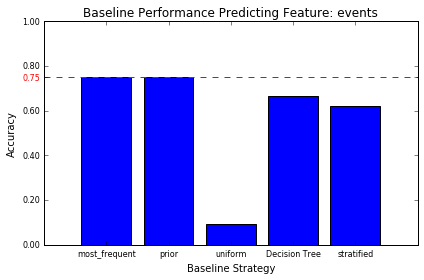

In [60]:
#Runs the decision tree algorithm on the dataset
from sklearn import tree
#Running default values, it is recommended to experiment with the values of the parameters below. Try min_samples_leaf=5
clf = tree.DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, max_features=None, max_leaf_nodes=None)
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
strats = baseline(data)
strats['Decision Tree'] = acc
plot_baseline(strats)

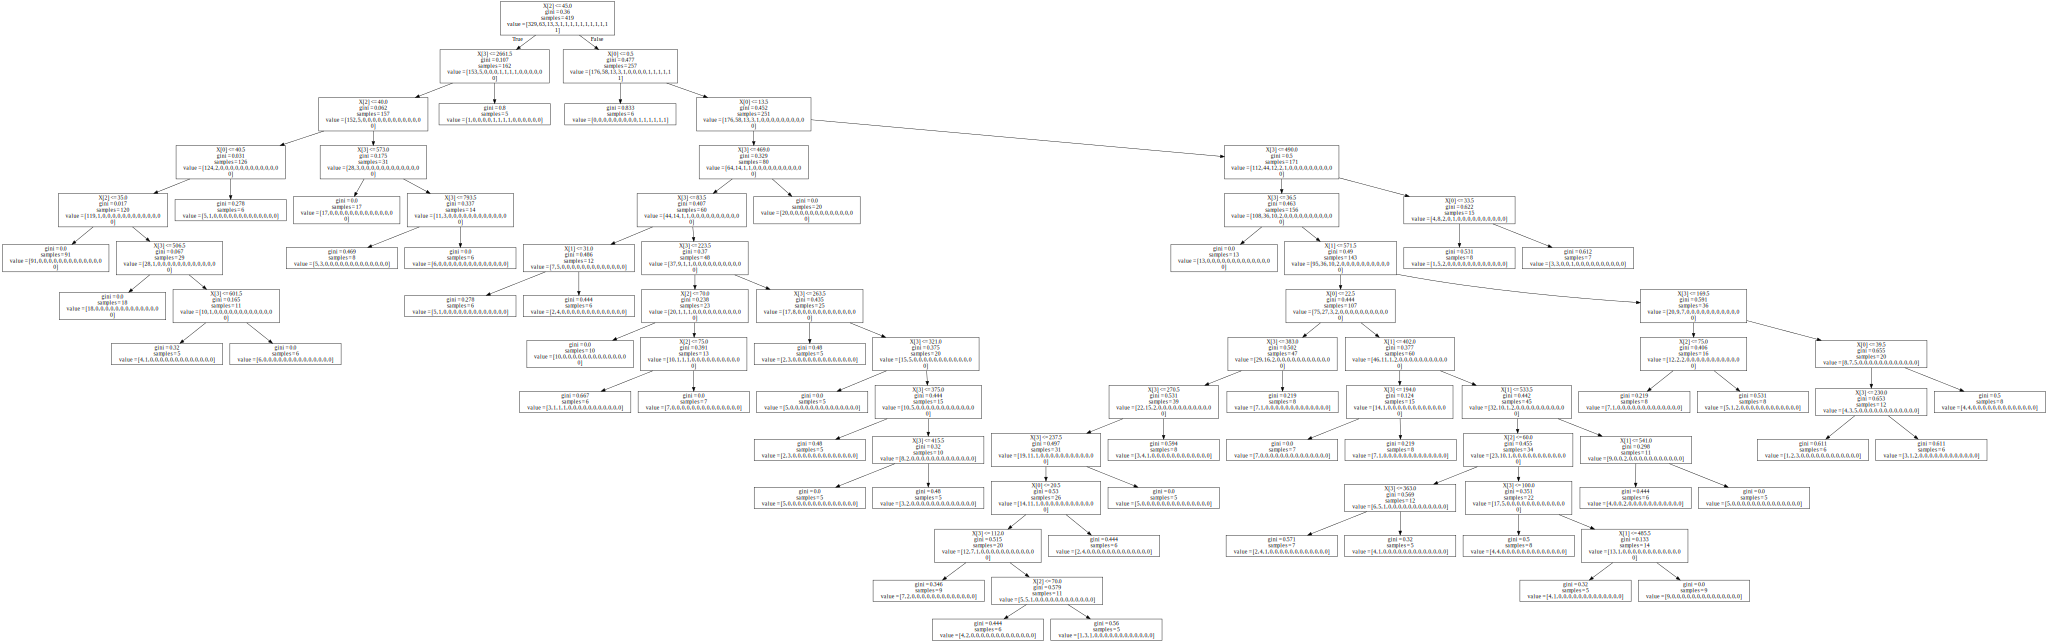

In [59]:
graph

Choose desired dataset and generate the most important plot. 

In [6]:
dataset = 536

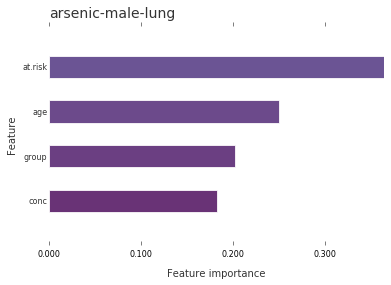

In [7]:
data = oml.datasets.get_dataset(dataset)
dataset_name, features, importances, indices = build_forest(data)
plot_feature_importances(features, importances, indices)

Plot of the classification baseline acuracy of the various baseline strategies using scikit-learn DummyClassifier.

The target feature is: **events**

The following baseline strategies are used: stratified, most_frequent, prior, uniform.

The strategies work as follow according to the sciki-learn API:

- **stratified**: Generates predictions by respecting the training set’s class distribution.

- **most_frequent**: Always predicts the most frequent label in the training set. Also known as ZeroR.

- **prior**: Always predicts the class that maximizes the class prior. 

- **uniform**: Generates predictions uniformly at random.

The horizontal red dotted line denotes the baseline value for this dataset which is equal to the best performing baseline strategy.

[More information.](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)


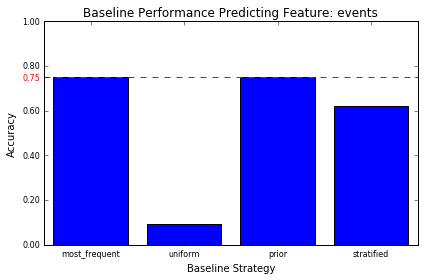

In [8]:
plot_baseline(baseline(data)) 